# AI Driven Crop Disease Prediction and Management System ResNet50

## CSPW007

In [2]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Problem Statement

- Utilize AI to predict crop diseases at an early stage, enabling timely intervention and minimizing crop loss.
- Implement sensors and data analytics to assess soil conditions and provide recommendations for optimal crop growth.
- Use AI to optimize pesticide application and irrigation, reducing waste and promoting sustainable farming.
- Integrate environmental data and predictive models to enhance crop management, prevent disease outbreaks, and improve overall yield.


Number of images of Pepper,_bell___Bacterial_spot: 1913 || Number of images of Pepper,_bell___healthy: 1988 || Total number of images we have 3901


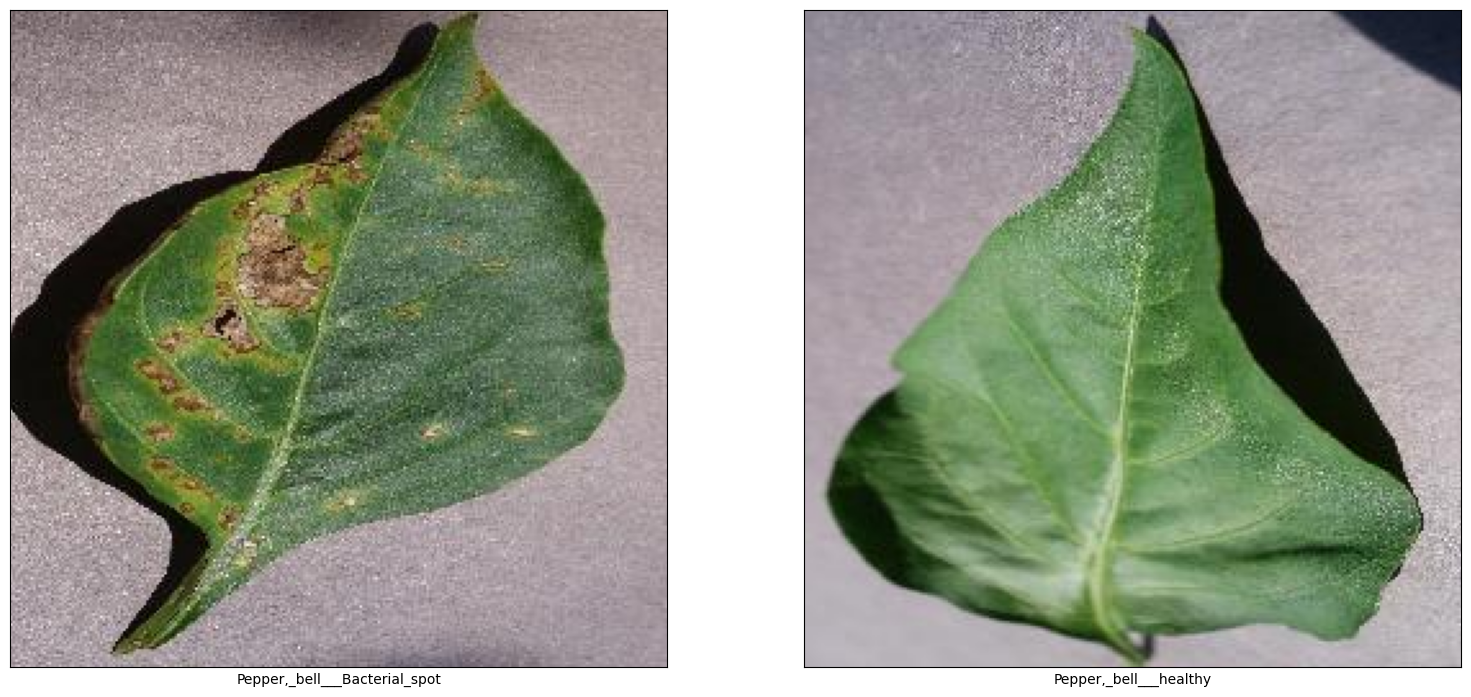

In [3]:
path='./Dataset/Pepper/train'
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end=" ")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)



  

In [4]:
print(plant_names)
print(len(plant_names))

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']
2


**IMPORTING NECESSARY LIBRARIES FOR TRAINING OF MODEL**

In [5]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


# RESNET50 IMPLEMENTATION USING KERAS API

**WHAT IS RENSET MODEL?**

## ResNet-50

-  ResNet-50 is a 50-layer deep convolutional neural network (CNN) used for image classification and feature extraction.
-  Utilizes residual connections (skip connections) to mitigate vanishing gradient problems and enable training of very deep networks.
-  Composed of convolutional layers, batch normalization, ReLU activation, and identity/shortcut connections.
- Extracts hierarchical features from images, making it useful for applications like object detection and medical diagnosis.
-  Available in deep learning frameworks like TensorFlow and PyTorch, often pre-trained on ImageNet for transfer learning.
-  Balances depth and computational efficiency, making it suitable for real-world applications including crop disease identification.


**WHY RESNET?**

## Why Use ResNet-50?

-  Provides high accuracy in image classification tasks, improving disease detection reliability.
-  Residual learning allows training of deeper networks without suffering from vanishing gradients.
- Allows transfer learning, reducing the need for large labeled datasets and speeding up training.
- Captures intricate patterns and textures in plant images, making it effective for crop disease identification.
- Can be fine-tuned and adapted to different crop diseases, improving model flexibility and performance.

In [6]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [7]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)


In [8]:
#Model building
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(2,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [13]:
#Image augmentation
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen=ImageDataGenerator()

path_train='./Dataset/Pepper/train'

path_valid='./Dataset/Pepper/valid'

train= train_datagen.flow_from_directory(directory=path_train,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')



Found 3901 images belonging to 2 classes.
Found 975 images belonging to 2 classes.


In [14]:
#CallBacks
import os
os.makedirs("./checkpoints", exist_ok=True)

es=EarlyStopping(monitor='val_accuracy',verbose=1,patience=7,mode='auto')
mc=ModelCheckpoint(filepath='./checkpoints/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=5,min_lr=0.001)

In [15]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
#Training
model_main.fit(train,validation_data=valid,epochs=30,verbose=1,callbacks=[mc,es,lr])

Epoch 1/30
122/122 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9249
Epoch 1: val_accuracy improved from -inf to 0.97333, saving model to ./checkpoints\model.h5
122/122 [==============================] - 90s 712ms/step - loss: 0.1875 - accuracy: 0.9249 - val_loss: 0.0660 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 2/30
122/122 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9800
Epoch 2: val_accuracy improved from 0.97333 to 0.99077, saving model to ./checkpoints\model.h5
122/122 [==============================] - 39s 321ms/step - loss: 0.0493 - accuracy: 0.9800 - val_loss: 0.0339 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 3/30
122/122 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9905
Epoch 3: val_accuracy improved from 0.99077 to 0.99692, saving model to ./checkpoints\model.h5
122/122 [==============================] - 40s 327ms/step - loss: 0.0255 - accuracy: 0.9905 - val_loss: 0.0089 - val_accuracy: 0.9969 - 

In [17]:
model_main.save("RESNET50_PLANT_DISEASE-T.h5")

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'loss')

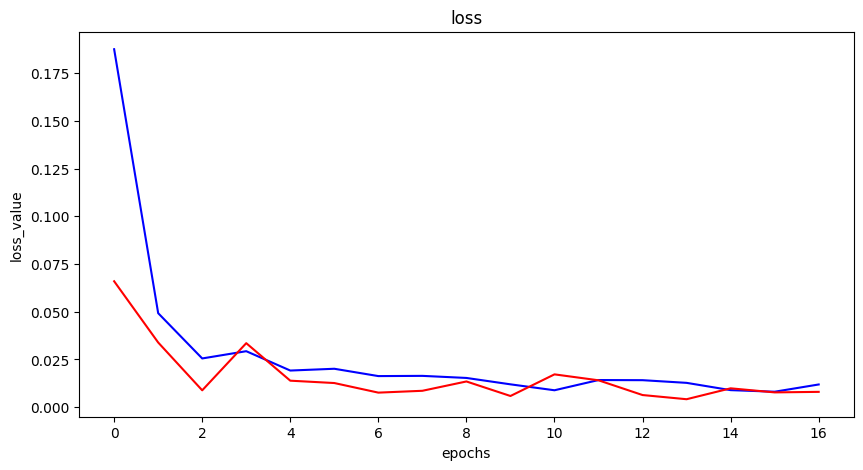

In [19]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")


Text(0.5, 1.0, 'accuracy graph')

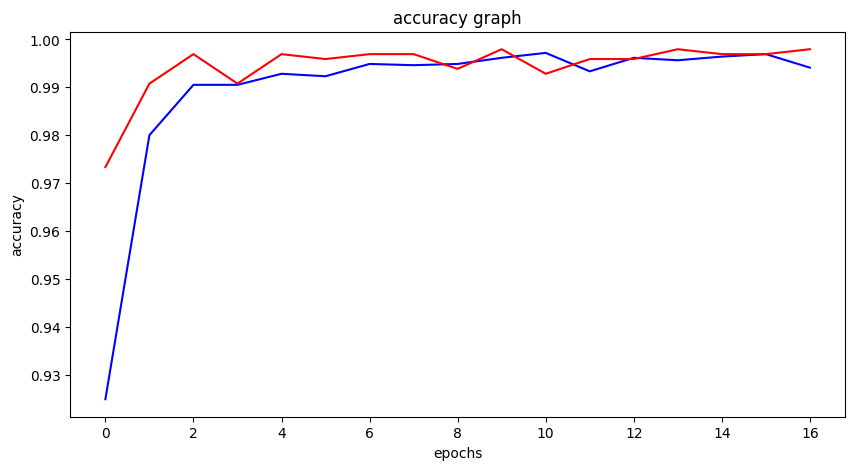

In [20]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")
